<a href="https://colab.research.google.com/github/Ingasha-Sharon/GABS-TABULAR/blob/main/GANs_for_Tabular_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'adult-census-income:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F225%2F498%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240708%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240708T184245Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5d95ceccff6dad063835647ca6854e7d4030d1291a18c97e67ae2d3a059bc1686fa187201b111f387610448717ccffa794a24c1ba8a08480fb321c054da32a98c790bd832990c4bf06752ac4c52be24a417bc0f30210ae9edd82f837bee161c00ee83f4540d229f0612e6e4424fa403d52f09f6fd3932d02ed6406a1b6c174d10fe15ccd0631a1ef81f5963a1fad66037a803882aa8282933e0f6567c4fbe25ca17b2b07036a3527f340fe603119396fd4c812636bf965be56ba05fa6ff2a97065cab995ae954a9a2f4b3ff1076ef2f7a26164267ff2e57abe54162b7b4efde81b49757a48eba55a434ffaa352266f68865ba0f8233462aa173acbc6b13b523f,ucuss:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F798662%2F1369970%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240708%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240708T184245Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4e3f1ed68ec372258bea3629f818260f5a4f850d8c9f136f68c4cd9231dd5a9322ce2352f092124332f2972d4d5361915f60de2496a02d81cd6baf5b459cc5bf3edfa048de1bc972edbf26ea10955f64b87b030ba321d648f71dd2dad00c1655af31d0588e4ec03c426aea1d6aa4b96cc08a344daa1d08d93274f96e1ff4776267e8b71c0b6fe380eb9aec5e893361ad8331b93ebbe1b16bd0058369fd19c139a85b728c940114abf91fd8856a1ff3d8df042ef0a708311a39d61bc88dc6f9088c028e00627caf10531e3e81e7063c6da35cdf5fb54b279af23eed439221c7a5b1e47122d779f8be86aa0969725992a09361924b7dcfb113a7f7b642f17d100c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 460936 bytes downloaded
Downloaded and uncompressed: adult-census-income
[==================================================] 644652 bytes downloaded
Downloaded and uncompressed: ucuss
Data source import complete.


#####<h1><center><font size="30">Generating Tabular Data using GANs</font></center></h1>

# Generative Adversarial Networks

Generative Adversarial Networks are type of unsupervised machine learning method which try to generate new, synthetic instances of data that mimics the real data.


## Conditional GAN

Conditional GAN or cGAN is a type of Generative Adversarial Network which adds the label y as an additional parameter to the generator in hope that the corresponding data will be generated.

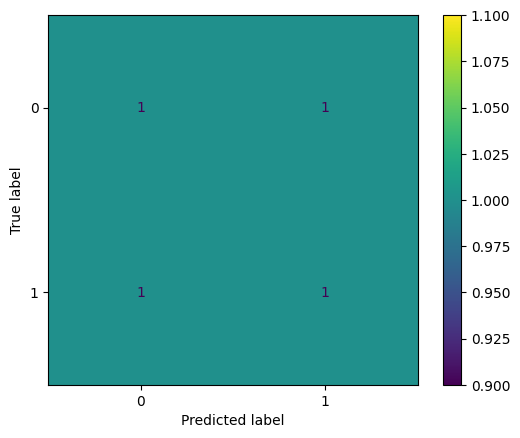

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            confusion_matrix # Removed plot_confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle

np.random.seed(1635848)

# If you need to plot the confusion matrix, use the following code:
from sklearn.metrics import ConfusionMatrixDisplay

# ... (your code to train a model and get predictions)

# Example placeholder for y_true and y_pred. Replace with your actual data.
y_true = [0, 1, 0, 1]
y_pred = [1, 1, 0, 0]

ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()

In [ ]:
class cGAN():

    """
    Class containing 3 methods (and __init__): generator, discriminator and train.
    Generator is trained using random noise and label as inputs. Discriminator is trained
    using real/fake samples and labels as inputs.
    """

    def __init__(self,latent_dim=32, out_shape=14):

        self.latent_dim = latent_dim
        self.out_shape = out_shape
        self.num_classes = 2
        # using Adam as our optimizer
        optimizer = Adam(0.0002, 0.5)

        # building the discriminator
        self.discriminator = self.discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # building the generator
        self.generator = self.generator()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])

        # we don't train discriminator when training generator
        self.discriminator.trainable = False
        valid = self.discriminator([gen_samples, label])

        # combining both models
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer,
                             metrics=['accuracy'])


    def generator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        gen_sample = model(model_input)

        return Model([noise, label], gen_sample, name="Generator")


    def discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(512, input_dim=self.out_shape, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(256, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(128, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(1, activation='sigmoid'))

        gen_sample = Input(shape=(self.out_shape,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))

        model_input = multiply([gen_sample, label_embedding])
        validity = model(model_input)

        return Model(inputs=[gen_sample, label], outputs=validity, name="Discriminator")


    def train(self, X_train, y_train, pos_index, neg_index, epochs, sampling=False, batch_size=32, sample_interval=100, plot=True):

        # though not recommended, defining losses as global helps as in analysing our cgan out of the class
        global G_losses
        global D_losses

        G_losses = []
        D_losses = []
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # if sampling==True --> train discriminator with 8 sample from postivite class and rest with negative class
            if sampling:
                idx1 = np.random.choice(pos_index, 8)
                idx0 = np.random.choice(neg_index, batch_size-8)
                idx = np.concatenate((idx1, idx0))
            # if sampling!=True --> train discriminator using random instances in batches of 32
            else:
                idx = np.random.choice(len(y_train), batch_size)
            samples, labels = X_train[idx], y_train[idx]
            samples, labels = shuffle(samples, labels)

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_samples = self.generator.predict([noise, labels])

            # label smoothing
            if epoch < epochs//1.5:
                valid_smooth = (valid+0.1)-(np.random.random(valid.shape)*0.1)
                fake_smooth = (fake-0.1)+(np.random.random(fake.shape)*0.1)
            else:
                valid_smooth = valid
                fake_smooth = fake

            # Train the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)
            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            if (epoch+1)%sample_interval==0:
                print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, d_loss[0], g_loss[0]))
            G_losses.append(g_loss[0])
            D_losses.append(d_loss[0])
            if plot:
                if epoch+1==epochs:
                    plt.figure(figsize=(10,5))
                    plt.title("Generator and Discriminator Loss")
                    plt.plot(G_losses,label="G")
                    plt.plot(D_losses,label="D")
                    plt.xlabel("iterations")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.show()

# Adult Census Income Dataset

In [ ]:
df = pd.read_csv('../input/adult-census-income/adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## Preprocessing

In [ ]:
le = preprocessing.LabelEncoder()
for i in ['workclass','education','marital.status','occupation','relationship','race','sex','native.country','income']:
    df[i] = le.fit_transform(df[i].astype(str))

In [ ]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,0,77053,11,9,6,0,1,4,0,0,4356,40,39,0
1,82,4,132870,11,9,6,4,1,4,0,0,4356,18,39,0
2,66,0,186061,15,10,6,0,4,2,0,0,4356,40,39,0
3,54,4,140359,5,4,0,7,4,4,0,0,3900,40,39,0
4,41,4,264663,15,10,5,10,3,4,0,0,3900,40,39,0


In [ ]:
df.income.value_counts()

income
0    24720
1     7841
Name: count, dtype: int64

### Splitting the dataframe

In [ ]:
scaler = StandardScaler()

# Drop the 'income' column along axis 1 (columns)
X = scaler.fit_transform(df.drop('income', axis=1))
y = df['income'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Classifying using real trainset

[LightGBM] [Info] Number of positive: 6229, number of negative: 19819
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 690
[LightGBM] [Info] Number of data points in the train set: 26048, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239135 -> initscore=-1.157425
[LightGBM] [Info] Start training from score -1.157425
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4901
           1       0.78      0.65      0.71      1612

    accuracy                           0.87      6513
   macro avg       0.84      0.80      0.81      6513
weighted avg       0.87      0.87      0.87      6513



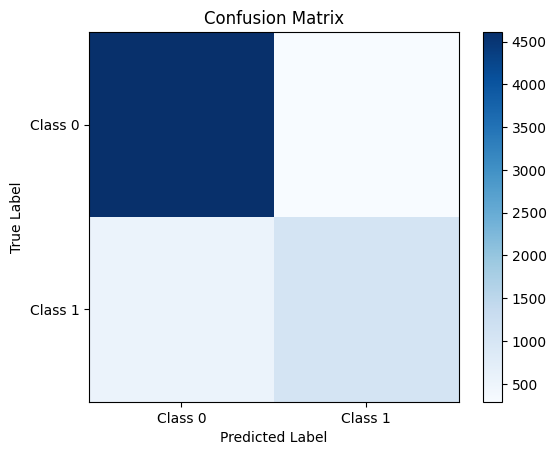

In [ ]:
!pip install lightgbm scikit-learn
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix # Import confusion_matrix instead
import matplotlib.pyplot as plt

lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train, y_train)

y_pred = lgb_1.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix using matplotlib
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Class 0', 'Class 1'])
plt.yticks([0, 1], ['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Training cGAN

In [ ]:
cgan = cGAN()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
y_train = y_train.reshape(-1,1)
pos_index = np.where(y_train==1)[0]
neg_index = np.where(y_train==0)[0]
cgan.train(X_train, y_train, pos_index, neg_index, epochs=500)

### Generating new instances

In [ ]:
# we want to generate 19758 instances with class value 0 since that represents how many 0s are in the label of the real training set
noise = np.random.normal(0, 1, (19758, 32))
sampled_labels = np.zeros(19758).reshape(-1, 1)


gen_samples = cgan.generator.predict([noise, sampled_labels])

gen_df = pd.DataFrame(data = gen_samples,
                      columns = df.drop('income',1).columns)

In [ ]:
# we want to generate 6290 instances with class value 1 since that represents how many 1s are in the label of the real training set
noise_2 = np.random.normal(0, 1, (6290, 32))
sampled_labels_2 = np.ones(6290).reshape(-1, 1)


gen_samples_2 = cgan.generator.predict([noise_2, sampled_labels_2])

gen_df_2 = pd.DataFrame(data = gen_samples_2,
                      columns = df.drop('income',1).columns)

### Combining generated instances into a dataframe

In [ ]:
gen_df_2['income'] = 1
gen_df['income']=0

df_gan = pd.concat([gen_df_2, gen_df], ignore_index=True, sort=False)
df_gan = df_gan.sample(frac=1).reset_index(drop=True)

X_train_2 = df_gan.drop('income', 1)
y_train_2 = df_gan['income'].values

### Classifying testset using generated trainset

In [ ]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train_2, y_train_2)


y_pred = lgb_1.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(lgb_1, X_test, y_test)
plt.show()

# Skin Segmentation Dataset

In [ ]:
df2 = pd.read_csv('../input/ucuss/Skin_NonSkin.txt', sep='\t', header=None, names=['B','G','R','Class'])
df2.Class = df2.Class.replace([1, 2], [0, 1])
df2.head()

,B,G,R,Class
0,74,85,123,0
1,73,84,122,0
2,72,83,121,0
3,70,81,119,0
4,70,81,119,0


In [ ]:
df2.Class.value_counts()

Class
1    194198
0     50859
Name: count, dtype: int64

### Splitting the Dataframe

In [ ]:
scaler = StandardScaler()

X = scaler.fit_transform(df2.drop('Class', 1))
y = df2['Class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Classifying using real trainset

In [ ]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train, y_train)


y_pred = lgb_1.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(lgb_1, X_test, y_test)
plt.show()

### Training cGAN

In [ ]:
cgan = cGAN(out_shape=3)

In [ ]:
y_train = y_train.reshape(-1,1)
pos_index = np.where(y_train==1)[0]
neg_index = np.where(y_train==0)[0]
cgan.train(X_train, y_train,pos_index, neg_index, epochs=100)

### Generating new instances

In [ ]:
# we want to generate 40572 instances with class value 0 since that represents how many 0s are in the label of the real training set
noise = np.random.normal(0, 1, (40572, 32))
sampled_labels = np.zeros(40572).reshape(-1, 1)


gen_samples = cgan.generator.predict([noise, sampled_labels])

gen_df = pd.DataFrame(data = gen_samples,
                      columns = df2.drop('Class',1).columns)
gen_df.head()

In [ ]:
# we want to generate 155473 instances with class value 1 since that represents how many 1s are in the real training set
noise_2 = np.random.normal(0, 1, (155473, 32))
sampled_labels_2 = np.ones(155473).reshape(-1, 1)


gen_samples_2 = cgan.generator.predict([noise_2, sampled_labels_2])

gen_df_2 = pd.DataFrame(data = gen_samples_2,
                      columns = df2.drop('Class',1).columns)
gen_df_2.head()

### Combining generated instances into a dataframe

In [ ]:
gen_df_2['Class'] = 1
gen_df['Class']=0

df_gan = pd.concat([gen_df_2, gen_df], ignore_index=True, sort=False)
df_gan = df_gan.sample(frac=1).reset_index(drop=True)

X_train_2 = df_gan.drop('Class', 1)
y_train_2 = df_gan['Class'].values

### Classifying testset using generated trainset

In [ ]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train_2, y_train_2)


y_pred = lgb_1.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(lgb_1, X_test, y_test)
plt.show()

## EXPERIMENTS

In [ ]:
def generate_instances(df_new, cgan,num_instances,label_class,label='income'):
    noise = np.random.normal(0, 1, (num_instances, 32))

    if label_class==0:
        sampled_labels = np.zeros(num_instances).reshape(-1, 1)
        gen_samples = cgan.generator.predict([noise, sampled_labels])
    else:
        sampled_labels = np.zeros(num_instances).reshape(-1, 1)
        gen_samples = cgan.generator.predict([noise, sampled_labels])

    gen_df = pd.DataFrame(data = gen_samples,
                          columns = df_new.drop(label,1).columns)
    return gen_df


In [ ]:
def run_experiment(df_new, pos_num_inst, neg_num_inst, num_epochs, out_sh, latent_d=32, label_f='income'):

    global bal_acc, acc, G_loss, D_loss
    G_loss = []
    D_loss = []
    bal_acc = []
    acc = []

    X = scaler.fit_transform(df_new.drop(label_f, 1))
    y = df_new[label_f].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    cgan=cGAN(latent_dim=latent_d, out_shape=out_sh)
    y_train = y_train.reshape(-1,1)
    pos_index = np.where(y_train==1)[0]
    neg_index = np.where(y_train==0)[0]

    for i in range(5):
        print(str(i+1)+". RUN")

        cgan.train(X_train, y_train, pos_index, neg_index, epochs=num_epochs, plot=False)
        gen_df = generate_instances(df_new, cgan=cgan,num_instances=pos_num_inst, label_class=1, label=label_f)
        gen_df_2 = generate_instances(df_new,cgan=cgan, num_instances=neg_num_inst, label_class=0, label=label_f)

        gen_df[label_f] = 1
        gen_df_2[label_f] = 0

        df_gan = pd.concat([gen_df_2, gen_df], ignore_index=True, sort=False)
        df_gan = df_gan.sample(frac=1).reset_index(drop=True)

        X_train_2 = df_gan.drop(label_f, 1)
        y_train_2 = df_gan[label_f].values

        lgb_1 = lgb.LGBMClassifier()
        lgb_1.fit(X_train_2, y_train_2)

        y_pred = lgb_1.predict(X_test)

        G_loss.append(G_losses)
        D_loss.append(D_losses)

        bal_acc.append(balanced_accuracy_score(y_test, y_pred))
        acc.append(accuracy_score(y_test, y_pred))

        print("Bal_Acc:", bal_acc[i])
        print("Acc:", acc[i])

    Sum_G_loss = [sum(x) for x in zip(*G_loss)]
    Sum_D_loss = [sum(x) for x in zip(*D_loss)]
    Avg_G_loss = [x / 5 for x in Sum_G_loss]
    Avg_D_loss = [x / 5 for x in Sum_D_loss]

    plt.figure(figsize=(10,5))
    plt.title("Average Generator and Discriminator Loss")
    plt.plot(Avg_G_loss,label="G")
    plt.plot(Avg_D_loss,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
%%time
run_experiment(df_new=df, pos_num_inst=6290, neg_num_inst=19758, num_epochs=2000, out_sh=14)

In [ ]:
%%time
run_experiment(df_new=df2, pos_num_inst=155289, neg_num_inst=40756, num_epochs=2000, out_sh=3,label_f='Class')